In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
batch = 256
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

mnist_indice = list(range(len(mnist)))



mnist_dataloader = DataLoader(mnist, shuffle=True, batch_size=batch)

In [3]:

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.output = nn.Sequential(nn.Linear(100, 256),#雜訊是長度100的tensor
                                    nn.LeakyReLU(),
                                    nn.Linear(256, 512),
                                    nn.LeakyReLU(),
                                    nn.Linear(512, 1024),
                                    nn.LeakyReLU(),
                                    nn.Linear(1024, 784),
                                    nn.Tanh())#輸出值域要藉於-1~1
    def forward(self, batch_size : int, use_gpu = False):
        x = torch.rand((batch_size, 100))
        if (use_gpu): 
            x = x.to(device="cuda", dtype=torch.float32)
        return self.output(x)
    def generate_image(self):
        image = self.forward(batch_size=1)
        image = image.view(-1, 28, 28).detach().numpy()
        image = (image + 1) * 255 / 2
        return image

In [4]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.output = nn.Sequential(nn.Linear(784, 1024),
                                    nn.LeakyReLU(),
                                    nn.Dropout(0.4),
                                    nn.Linear(1024, 512),
                                    nn.LeakyReLU(),
                                    nn.Dropout(0.3),
                                    nn.Linear(512, 256),
                                    nn.BatchNorm1d(256),
                                    nn.LeakyReLU(),
                                    nn.Linear(256, 1),
                                    nn.Sigmoid()
                                    )
    def forward(self, x):
        x = x.view(-1, 784)
        return self.output(x)

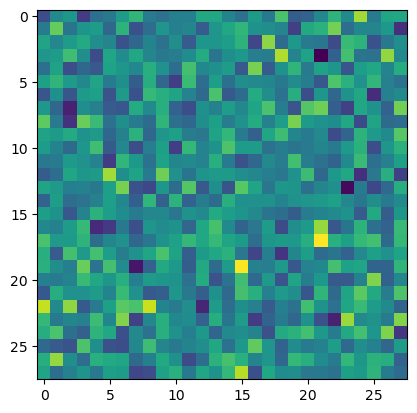

In [5]:
generator = Generator()
classifier = Classifier()


image = generator.generate_image()
plt.imshow(image[0])
plt.show()

In [6]:
use_gpu = torch.cuda.is_available()

epoch = 1000
lr = 0.0002
beta = (0.5, 0.999)

optim_G = optim.Adam(generator.parameters(), lr=lr, betas=beta)
optim_C = optim.Adam(classifier.parameters(), lr=lr, betas=beta)
loss_function = nn.BCELoss()

fake_label = torch.ones(2*batch)#整個在騙的標籤會一直用到

if (use_gpu):
    print("GPU")
    loss_function = loss_function.to(device="cuda", dtype=torch.float32)
    #generator = generator.to(device="cuda", dtype=torch.float32)
    classifier = classifier.to(device="cuda", dtype=torch.float32)
    fake_label = fake_label.to(device="cuda", dtype=torch.float32)

GPU


epoch: 1:
classifier loss: 0.019394158669053873
generator loss: 0.21458541380589521
epoch: 2:
classifier loss: 0.018371386891429094
generator loss: 0.07125086297622901
epoch: 3:
classifier loss: 0.03667654729884197
generator loss: 0.03777426508276357
epoch: 4:
classifier loss: 0.05194626834659659
generator loss: 0.039360091415205425
epoch: 5:
classifier loss: 0.05313809440728832
generator loss: 0.04083865692614865
epoch: 6:
classifier loss: 0.03984667474423793
generator loss: 0.03209746105105993
epoch: 7:
classifier loss: 0.026196432568410293
generator loss: 0.05455604447692786
epoch: 8:
classifier loss: 0.03450127641690221
generator loss: 0.04091603131840957
epoch: 9:
classifier loss: 0.00629615104420388
generator loss: 0.033278897301011544
epoch: 10:
classifier loss: 0.028412507446680932
generator loss: 0.031039933689889755
epoch: 11:
classifier loss: 0.042005813899053696
generator loss: 0.03329821587229433
epoch: 12:
classifier loss: 0.062015246055485244
generator loss: 0.0391248435

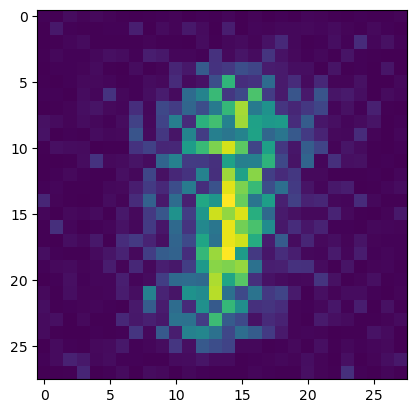

epoch: 51:
classifier loss: 0.0018317554862810636
generator loss: 0.042671866161519106
epoch: 52:
classifier loss: 0.006308518667232265
generator loss: 0.03864941853361744
epoch: 53:
classifier loss: 0.0014078949215856598
generator loss: 0.06775812332554314
epoch: 54:
generator loss: 8.46340129352571e-05
epoch: 55:
classifier loss: 0.001152437609283531
generator loss: 0.06894801888836886
epoch: 56:
generator loss: 1.7934599929232833e-05
epoch: 57:
classifier loss: 0.002742705598103249
generator loss: 0.04325598140307232
epoch: 58:
classifier loss: 0.003149513221100317
generator loss: 0.04667238797627703
epoch: 59:
classifier loss: 0.003853736375706231
generator loss: 0.05716708723453616
epoch: 60:
generator loss: 4.824281451022971e-06
epoch: 61:
classifier loss: 0.004918546196224386
generator loss: 0.04588248803660502
epoch: 62:
classifier loss: 0.0027536528618161645
generator loss: 0.04186811458158116
epoch: 63:
classifier loss: 0.0031531725361499878
generator loss: 0.0448006190530887

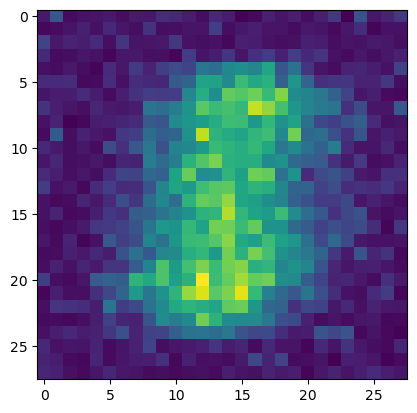

epoch: 101:
classifier loss: 0.003892156261521295
generator loss: 0.04448733719057605
epoch: 102:
classifier loss: 0.0031312449221119055
generator loss: 0.045642825818476146
epoch: 103:
classifier loss: 0.0017365197537111137
generator loss: 0.047478340778209886
epoch: 104:
classifier loss: 0.002737397721300132
generator loss: 0.047754297576721776
epoch: 105:
classifier loss: 0.003231777140551477
generator loss: 0.078877755936156
epoch: 106:
generator loss: 0.0
epoch: 107:
classifier loss: 0.0043329861611864735
generator loss: 0.046887619727660534
epoch: 108:
classifier loss: 0.0026655360285540736
generator loss: 0.06768906733034763
epoch: 109:
generator loss: 1.0548216453165143e-05
epoch: 110:
classifier loss: 0.0023507125094840106
generator loss: 0.05149358530687903
epoch: 111:
generator loss: 6.9353817015579434e-12
epoch: 112:
classifier loss: 0.007478059920422891
generator loss: 0.05047800953511119
epoch: 113:
generator loss: 7.197639634564148e-07
epoch: 114:
classifier loss: 0.0034

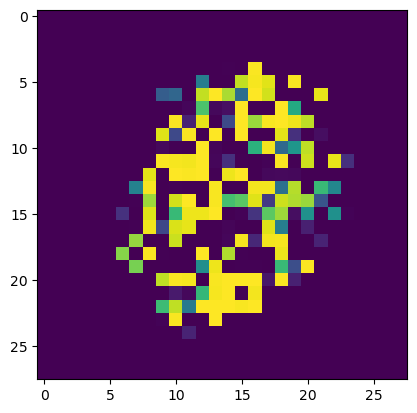

epoch: 151:
classifier loss: 0.00403510264580465
generator loss: 0.11855677219722036
epoch: 152:
generator loss: 0.0
epoch: 153:
classifier loss: 0.05282758636950599
generator loss: 0.048115495306052115
epoch: 154:
classifier loss: 0.010561166067379824
generator loss: 0.08281708844049408
epoch: 155:
generator loss: 7.202117044374624e-05
epoch: 156:
classifier loss: 0.0017888677470569321
generator loss: 0.21653429124650775
epoch: 157:
generator loss: 2.4361386029805214e-05
epoch: 158:
classifier loss: 0.002179636537782263
generator loss: 0.10419948364016934
epoch: 159:
generator loss: 1.3692918489934837e-05
epoch: 160:
classifier loss: 0.0015359860542416078
generator loss: 0.07129160268876227
epoch: 161:
generator loss: 0.0004911721077192812
epoch: 162:
classifier loss: 0.0006844452562484335
generator loss: 0.5119422781365388
epoch: 163:
generator loss: 0.0009999654404422703
epoch: 164:
classifier loss: 0.0007051791732900458
generator loss: 0.8511038263189665
epoch: 165:
generator loss:

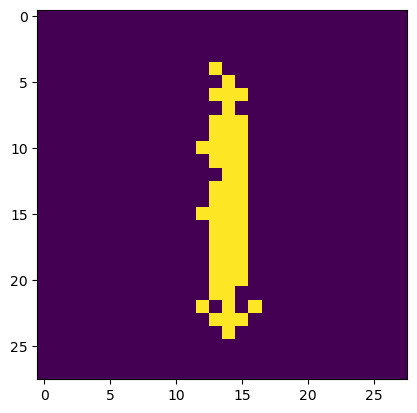

epoch: 201:
generator loss: 4.778785705566406
epoch: 202:
generator loss: 4.778785705566406
epoch: 203:
generator loss: 4.778785705566406
epoch: 204:
generator loss: 4.778785705566406
epoch: 205:
generator loss: 4.778785705566406
epoch: 206:
generator loss: 4.778785705566406
epoch: 207:
generator loss: 4.778785705566406
epoch: 208:
generator loss: 4.778785705566406
epoch: 209:
generator loss: 4.778785705566406
epoch: 210:
generator loss: 4.778785705566406
epoch: 211:
generator loss: 4.778785705566406
epoch: 212:
generator loss: 4.778785705566406
epoch: 213:
generator loss: 4.778785705566406
epoch: 214:
generator loss: 4.778785705566406
epoch: 215:
generator loss: 4.778785705566406
epoch: 216:
generator loss: 4.778785705566406
epoch: 217:
generator loss: 4.778785705566406
epoch: 218:
generator loss: 4.778785705566406
epoch: 219:
generator loss: 4.778785705566406
epoch: 220:
generator loss: 4.778785705566406
epoch: 221:
generator loss: 4.778785705566406
epoch: 222:
generator loss: 4.7787

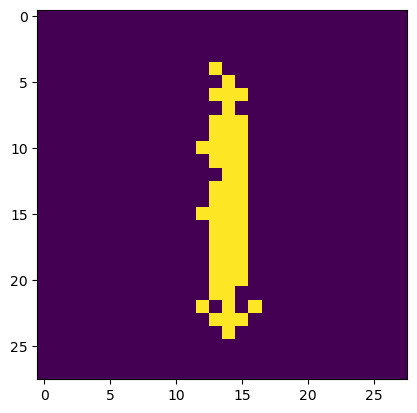

epoch: 251:
generator loss: 4.778785705566406
epoch: 252:
generator loss: 4.778785705566406
epoch: 253:
generator loss: 4.778785705566406
epoch: 254:
generator loss: 4.778785705566406
epoch: 255:
generator loss: 4.778785705566406
epoch: 256:
generator loss: 4.778785705566406
epoch: 257:
generator loss: 4.778785705566406
epoch: 258:
generator loss: 4.778785705566406
epoch: 259:
generator loss: 4.778785705566406
epoch: 260:
generator loss: 4.778785705566406
epoch: 261:
generator loss: 4.778785705566406
epoch: 262:
generator loss: 4.778785705566406
epoch: 263:
generator loss: 4.778785705566406
epoch: 264:
generator loss: 4.778785705566406
epoch: 265:
generator loss: 4.778785705566406
epoch: 266:
generator loss: 4.778785705566406
epoch: 267:
generator loss: 4.778785705566406
epoch: 268:
generator loss: 4.778785705566406
epoch: 269:
generator loss: 4.778785705566406
epoch: 270:
generator loss: 4.778785705566406
epoch: 271:
generator loss: 4.778785705566406
epoch: 272:
generator loss: 4.7787

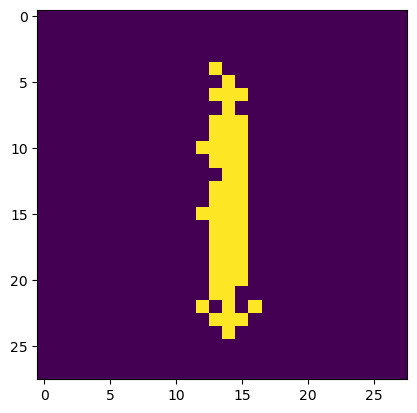

epoch: 301:
generator loss: 4.778785705566406
epoch: 302:
generator loss: 4.778785705566406
epoch: 303:
generator loss: 4.778785705566406
epoch: 304:
generator loss: 4.778785705566406
epoch: 305:
generator loss: 4.778785705566406
epoch: 306:
generator loss: 4.778785705566406
epoch: 307:
generator loss: 4.778785705566406
epoch: 308:
generator loss: 4.778785705566406
epoch: 309:
generator loss: 4.778785705566406
epoch: 310:
generator loss: 4.778785705566406
epoch: 311:
generator loss: 4.778785705566406
epoch: 312:
generator loss: 4.778785705566406
epoch: 313:
generator loss: 4.778785705566406
epoch: 314:
generator loss: 4.778785705566406
epoch: 315:
generator loss: 4.778785705566406
epoch: 316:
generator loss: 4.778785705566406
epoch: 317:
generator loss: 4.778785705566406
epoch: 318:
generator loss: 4.778785705566406
epoch: 319:
generator loss: 4.778785705566406
epoch: 320:
generator loss: 4.778785705566406
epoch: 321:
generator loss: 4.778785705566406
epoch: 322:
generator loss: 4.7787

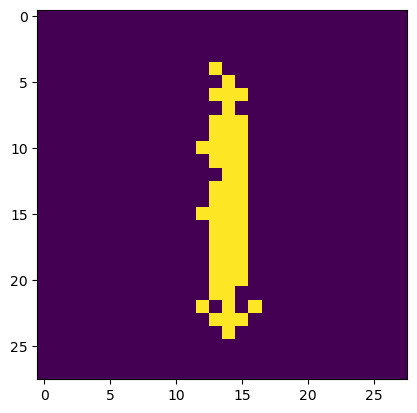

epoch: 351:
generator loss: 4.778785705566406
epoch: 352:
generator loss: 4.778785705566406
epoch: 353:
generator loss: 4.778785705566406
epoch: 354:
generator loss: 4.778785705566406
epoch: 355:
generator loss: 4.778785705566406
epoch: 356:
generator loss: 4.778785705566406
epoch: 357:
generator loss: 4.778785705566406
epoch: 358:
generator loss: 4.778785705566406
epoch: 359:
generator loss: 4.778785705566406
epoch: 360:
generator loss: 4.778785705566406
epoch: 361:
generator loss: 4.778785705566406
epoch: 362:
generator loss: 4.778785705566406
epoch: 363:
generator loss: 4.778785705566406
epoch: 364:
generator loss: 4.778785705566406
epoch: 365:
generator loss: 4.778785705566406
epoch: 366:
generator loss: 4.778785705566406
epoch: 367:
generator loss: 4.778785705566406
epoch: 368:
generator loss: 4.778785705566406
epoch: 369:
generator loss: 4.778785705566406
epoch: 370:
generator loss: 4.778785705566406
epoch: 371:
generator loss: 4.778785705566406
epoch: 372:
generator loss: 4.7787

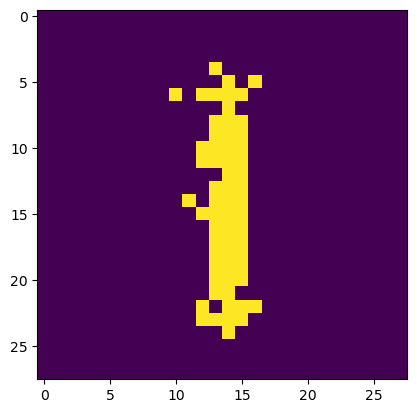

epoch: 401:
generator loss: 10.213651657104492
epoch: 402:
generator loss: 10.213651657104492
epoch: 403:
generator loss: 10.213651657104492
epoch: 404:
generator loss: 10.213651657104492
epoch: 405:
generator loss: 10.213651657104492
epoch: 406:
generator loss: 10.213651657104492
epoch: 407:
generator loss: 10.213651657104492
epoch: 408:
generator loss: 10.213651657104492
epoch: 409:
generator loss: 10.213651657104492
epoch: 410:
generator loss: 10.213651657104492
epoch: 411:
generator loss: 10.213651657104492
epoch: 412:
generator loss: 10.213651657104492
epoch: 413:
generator loss: 10.213651657104492
epoch: 414:
generator loss: 10.213651657104492
epoch: 415:
generator loss: 10.213651657104492
epoch: 416:
generator loss: 10.213651657104492
epoch: 417:
generator loss: 10.213651657104492
epoch: 418:
generator loss: 10.213651657104492
epoch: 419:
generator loss: 10.213651657104492
epoch: 420:
generator loss: 10.213651657104492
epoch: 421:
generator loss: 10.213651657104492
epoch: 422:
g

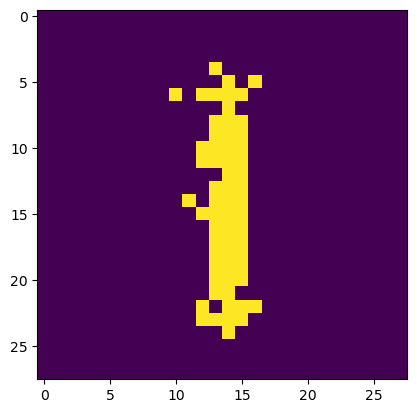

epoch: 451:
generator loss: 10.213651657104492
epoch: 452:
generator loss: 10.213651657104492
epoch: 453:
generator loss: 10.213651657104492
epoch: 454:
generator loss: 10.213651657104492
epoch: 455:
generator loss: 10.213651657104492
epoch: 456:
generator loss: 10.213651657104492
epoch: 457:
generator loss: 10.213651657104492
epoch: 458:
generator loss: 10.213651657104492
epoch: 459:
generator loss: 10.213651657104492
epoch: 460:
generator loss: 10.213651657104492
epoch: 461:
generator loss: 10.213651657104492
epoch: 462:
generator loss: 10.213651657104492
epoch: 463:
generator loss: 10.213651657104492
epoch: 464:
generator loss: 10.213651657104492
epoch: 465:
generator loss: 10.213651657104492
epoch: 466:
generator loss: 10.213651657104492
epoch: 467:
generator loss: 10.213651657104492
epoch: 468:
generator loss: 10.213651657104492
epoch: 469:
generator loss: 10.213651657104492
epoch: 470:
generator loss: 10.213651657104492
epoch: 471:
generator loss: 10.213651657104492
epoch: 472:
g

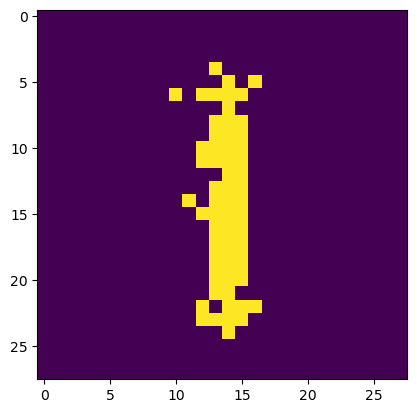

epoch: 501:
generator loss: 10.213651657104492
epoch: 502:
generator loss: 10.213651657104492
epoch: 503:
generator loss: 10.213651657104492
epoch: 504:
generator loss: 10.213651657104492
epoch: 505:
generator loss: 10.213651657104492
epoch: 506:
generator loss: 10.213651657104492
epoch: 507:
generator loss: 10.213651657104492
epoch: 508:
generator loss: 10.213651657104492
epoch: 509:
generator loss: 10.213651657104492
epoch: 510:
generator loss: 10.213651657104492
epoch: 511:
generator loss: 10.213651657104492
epoch: 512:
generator loss: 10.213651657104492
epoch: 513:
generator loss: 10.213651657104492
epoch: 514:
generator loss: 10.213651657104492
epoch: 515:
generator loss: 10.213651657104492
epoch: 516:
generator loss: 10.213651657104492
epoch: 517:
generator loss: 10.213651657104492
epoch: 518:
generator loss: 10.213651657104492
epoch: 519:
generator loss: 10.213651657104492
epoch: 520:
generator loss: 10.213651657104492
epoch: 521:
generator loss: 10.213651657104492
epoch: 522:
g

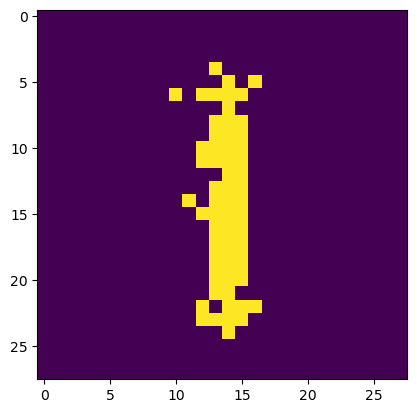

epoch: 551:
generator loss: 10.213651657104492
epoch: 552:
generator loss: 10.213651657104492
epoch: 553:
generator loss: 10.213651657104492
epoch: 554:
generator loss: 10.213651657104492
epoch: 555:
generator loss: 10.213651657104492
epoch: 556:
generator loss: 10.213651657104492
epoch: 557:
generator loss: 10.213651657104492
epoch: 558:
generator loss: 10.213651657104492
epoch: 559:
generator loss: 10.213651657104492
epoch: 560:
generator loss: 10.213651657104492
epoch: 561:
generator loss: 10.213651657104492
epoch: 562:
generator loss: 10.213651657104492
epoch: 563:
generator loss: 10.213651657104492
epoch: 564:
generator loss: 10.213651657104492
epoch: 565:
generator loss: 10.213651657104492
epoch: 566:
generator loss: 10.213651657104492
epoch: 567:
generator loss: 10.213651657104492
epoch: 568:
generator loss: 10.213651657104492
epoch: 569:
generator loss: 10.213651657104492
epoch: 570:
generator loss: 10.213651657104492
epoch: 571:
generator loss: 10.213651657104492
epoch: 572:
g

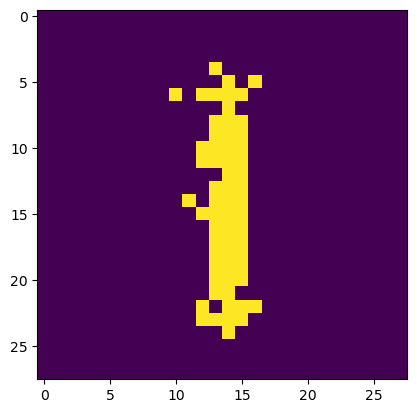

epoch: 601:
generator loss: 10.213651657104492
epoch: 602:
generator loss: 10.213651657104492
epoch: 603:
generator loss: 10.213651657104492
epoch: 604:
generator loss: 10.213651657104492
epoch: 605:
generator loss: 10.213651657104492
epoch: 606:
generator loss: 10.213651657104492
epoch: 607:
generator loss: 10.213651657104492
epoch: 608:
generator loss: 10.213651657104492
epoch: 609:
generator loss: 10.213651657104492
epoch: 610:
generator loss: 10.213651657104492
epoch: 611:
generator loss: 10.213651657104492
epoch: 612:
generator loss: 10.213651657104492
epoch: 613:
generator loss: 10.213651657104492
epoch: 614:
generator loss: 10.213651657104492
epoch: 615:
generator loss: 10.213651657104492
epoch: 616:
generator loss: 10.213651657104492
epoch: 617:
generator loss: 10.213651657104492
epoch: 618:
generator loss: 10.213651657104492
epoch: 619:
generator loss: 10.213651657104492
epoch: 620:
generator loss: 10.213651657104492
epoch: 621:
generator loss: 10.213651657104492
epoch: 622:
g

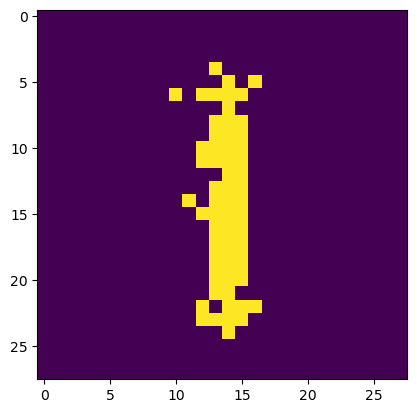

epoch: 651:
generator loss: 10.213651657104492
epoch: 652:
generator loss: 10.213651657104492
epoch: 653:
generator loss: 10.213651657104492
epoch: 654:
generator loss: 10.213651657104492
epoch: 655:
generator loss: 10.213651657104492
epoch: 656:
generator loss: 10.213651657104492
epoch: 657:
generator loss: 10.213651657104492
epoch: 658:
generator loss: 10.213651657104492
epoch: 659:
generator loss: 10.213651657104492
epoch: 660:
generator loss: 10.213651657104492
epoch: 661:
generator loss: 10.213651657104492
epoch: 662:
generator loss: 10.213651657104492
epoch: 663:
generator loss: 10.213651657104492
epoch: 664:
generator loss: 10.213651657104492
epoch: 665:
generator loss: 10.213651657104492
epoch: 666:
generator loss: 10.213651657104492
epoch: 667:
generator loss: 10.213651657104492
epoch: 668:
generator loss: 10.213651657104492
epoch: 669:
generator loss: 10.213651657104492
epoch: 670:
generator loss: 10.213651657104492
epoch: 671:
generator loss: 10.213651657104492
epoch: 672:
g

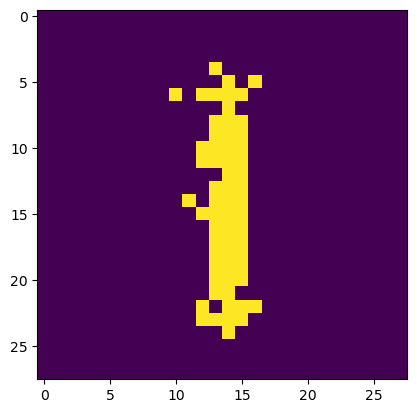

epoch: 701:
generator loss: 10.213651657104492
epoch: 702:
generator loss: 10.213651657104492
epoch: 703:
generator loss: 10.213651657104492
epoch: 704:
generator loss: 10.213651657104492
epoch: 705:
generator loss: 10.213651657104492
epoch: 706:
generator loss: 10.213651657104492
epoch: 707:
generator loss: 10.213651657104492
epoch: 708:
generator loss: 10.213651657104492
epoch: 709:
generator loss: 10.213651657104492
epoch: 710:
generator loss: 10.213651657104492
epoch: 711:
generator loss: 10.213651657104492
epoch: 712:
generator loss: 10.213651657104492
epoch: 713:
generator loss: 10.213651657104492
epoch: 714:
generator loss: 10.213651657104492
epoch: 715:
generator loss: 10.213651657104492
epoch: 716:
generator loss: 10.213651657104492
epoch: 717:
generator loss: 10.213651657104492
epoch: 718:
generator loss: 10.213651657104492
epoch: 719:
generator loss: 10.213651657104492
epoch: 720:
generator loss: 10.213651657104492
epoch: 721:
generator loss: 10.213651657104492
epoch: 722:
g

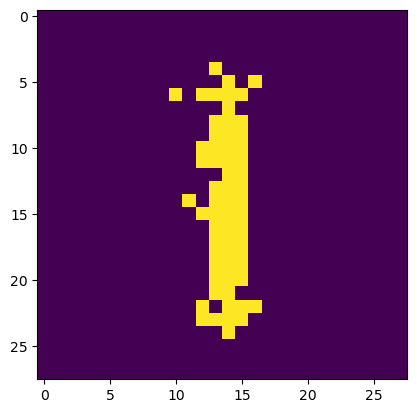

epoch: 751:
generator loss: 10.213651657104492
epoch: 752:
generator loss: 10.213651657104492
epoch: 753:
generator loss: 10.213651657104492
epoch: 754:
generator loss: 10.213651657104492
epoch: 755:
generator loss: 10.213651657104492
epoch: 756:
generator loss: 10.213651657104492
epoch: 757:
generator loss: 10.213651657104492
epoch: 758:
generator loss: 10.213651657104492
epoch: 759:
generator loss: 10.213651657104492
epoch: 760:
generator loss: 10.213651657104492
epoch: 761:
generator loss: 10.213651657104492
epoch: 762:
generator loss: 10.213651657104492
epoch: 763:
generator loss: 10.213651657104492
epoch: 764:
generator loss: 10.213651657104492
epoch: 765:
generator loss: 10.213651657104492
epoch: 766:
generator loss: 10.213651657104492
epoch: 767:
generator loss: 10.213651657104492
epoch: 768:
generator loss: 10.213651657104492
epoch: 769:
generator loss: 10.213651657104492
epoch: 770:
generator loss: 10.213651657104492
epoch: 771:
generator loss: 10.213651657104492
epoch: 772:
g

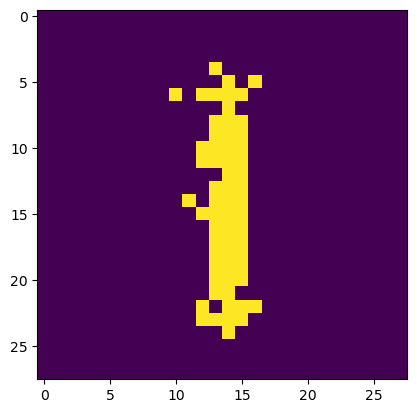

epoch: 801:
generator loss: 10.213651657104492
epoch: 802:
generator loss: 10.213651657104492
epoch: 803:
generator loss: 10.213651657104492
epoch: 804:
generator loss: 10.213651657104492
epoch: 805:
generator loss: 10.213651657104492
epoch: 806:
generator loss: 10.213651657104492
epoch: 807:
generator loss: 10.213651657104492
epoch: 808:
generator loss: 10.213651657104492
epoch: 809:
generator loss: 10.213651657104492
epoch: 810:
generator loss: 10.213651657104492
epoch: 811:
generator loss: 10.213651657104492
epoch: 812:
generator loss: 10.213651657104492
epoch: 813:
generator loss: 10.213651657104492
epoch: 814:
generator loss: 10.213651657104492
epoch: 815:
generator loss: 10.213651657104492
epoch: 816:
generator loss: 10.213651657104492
epoch: 817:
generator loss: 10.213651657104492
epoch: 818:
generator loss: 10.213651657104492
epoch: 819:
generator loss: 10.213651657104492
epoch: 820:
generator loss: 10.213651657104492
epoch: 821:
generator loss: 10.213651657104492
epoch: 822:
g

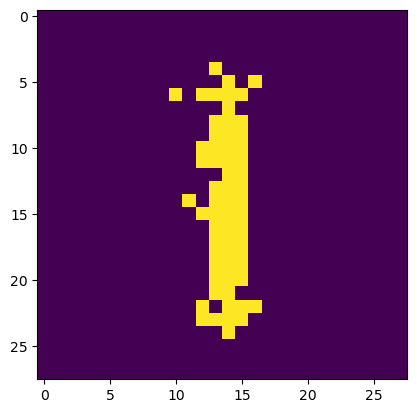

epoch: 851:
generator loss: 10.213651657104492
epoch: 852:
generator loss: 10.213651657104492
epoch: 853:
generator loss: 10.213651657104492
epoch: 854:
generator loss: 10.213651657104492
epoch: 855:
generator loss: 10.213651657104492
epoch: 856:
generator loss: 10.213651657104492
epoch: 857:
generator loss: 10.213651657104492
epoch: 858:
generator loss: 10.213651657104492
epoch: 859:
generator loss: 10.213651657104492
epoch: 860:
generator loss: 10.213651657104492
epoch: 861:
generator loss: 10.213651657104492
epoch: 862:
generator loss: 10.213651657104492
epoch: 863:
generator loss: 10.213651657104492
epoch: 864:
generator loss: 10.213651657104492
epoch: 865:
generator loss: 10.213651657104492
epoch: 866:
generator loss: 10.213651657104492
epoch: 867:
generator loss: 10.213651657104492
epoch: 868:
generator loss: 10.213651657104492
epoch: 869:
generator loss: 10.213651657104492
epoch: 870:
generator loss: 10.213651657104492
epoch: 871:
generator loss: 10.213651657104492
epoch: 872:
g

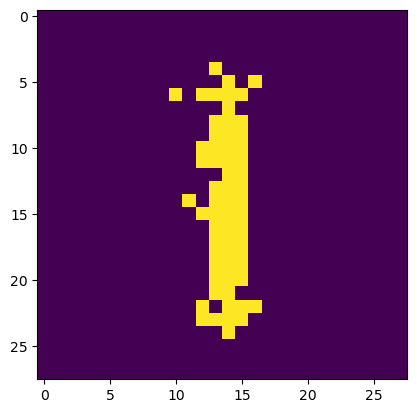

epoch: 901:
generator loss: 10.213651657104492
epoch: 902:
generator loss: 10.213651657104492
epoch: 903:
generator loss: 10.213651657104492
epoch: 904:
generator loss: 10.213651657104492
epoch: 905:
generator loss: 10.213651657104492
epoch: 906:
generator loss: 10.213651657104492
epoch: 907:
generator loss: 10.213651657104492
epoch: 908:
generator loss: 10.213651657104492
epoch: 909:
generator loss: 10.213651657104492
epoch: 910:
generator loss: 10.213651657104492
epoch: 911:
generator loss: 10.213651657104492
epoch: 912:
generator loss: 10.213651657104492
epoch: 913:
generator loss: 10.213651657104492
epoch: 914:
generator loss: 10.213651657104492
epoch: 915:
generator loss: 10.213651657104492
epoch: 916:
generator loss: 10.213651657104492
epoch: 917:
generator loss: 10.213651657104492
epoch: 918:
generator loss: 10.213651657104492
epoch: 919:
generator loss: 10.213651657104492
epoch: 920:
generator loss: 10.213651657104492
epoch: 921:
generator loss: 10.213651657104492
epoch: 922:
g

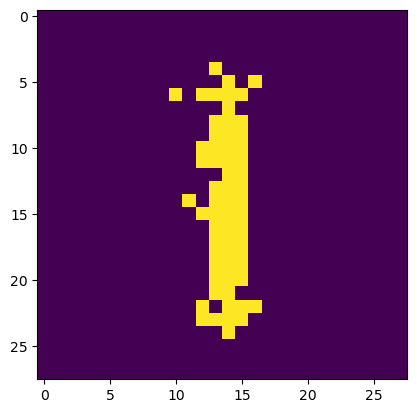

epoch: 951:
generator loss: 10.213651657104492
epoch: 952:
generator loss: 10.213651657104492
epoch: 953:
generator loss: 10.213651657104492
epoch: 954:
generator loss: 10.213651657104492
epoch: 955:
generator loss: 10.213651657104492
epoch: 956:
generator loss: 10.213651657104492
epoch: 957:
generator loss: 10.213651657104492
epoch: 958:
generator loss: 10.213651657104492
epoch: 959:
generator loss: 10.213651657104492
epoch: 960:
generator loss: 10.213651657104492
epoch: 961:
generator loss: 10.213651657104492
epoch: 962:
generator loss: 10.213651657104492
epoch: 963:
generator loss: 10.213651657104492
epoch: 964:
generator loss: 10.213651657104492
epoch: 965:
generator loss: 10.213651657104492
epoch: 966:
generator loss: 10.213651657104492
epoch: 967:
generator loss: 10.213651657104492
epoch: 968:
generator loss: 10.213651657104492
epoch: 969:
generator loss: 10.213651657104492
epoch: 970:
generator loss: 10.213651657104492
epoch: 971:
generator loss: 10.213651657104492
epoch: 972:
g

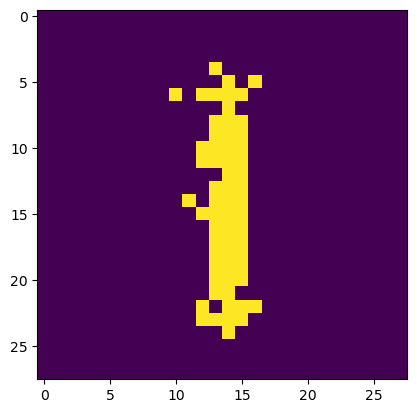

In [7]:
classifier_loss = [1]
generator_loss = [0]
count = 235
for i in range(epoch):
    print(f"epoch: {i + 1}:")
    
    classifier_loss_epoch = 0
    generator_loss_epoch = 0
    
    classifier.train()

    if (i < 10 or generator_loss[len(generator_loss) - 1] < 0.05):
        for x, y in mnist_dataloader:
            optim_C.zero_grad()

            #reshape mnist data
            x = x.view(-1, 784)     
            #生成假資料
            with torch.no_grad(): fake_mnist = generator(batch_size=len(x))#不要被訓練到

            #合併資料
            train_data = torch.cat((x, fake_mnist))                        
            train_label = torch.cat((torch.ones(len(x)), torch.zeros(len(x))))

            #生成隨機排序
            random_indice = torch.randperm(2 * len(x))

            #隨機分布
            train_data = train_data[random_indice] 
            train_label = train_label[random_indice]

            
            if (use_gpu): 
                train_data = train_data.to(device="cuda", dtype=torch.float32)
                train_label = train_label.to(device="cuda", dtype=torch.float32)

            predict = classifier(train_data)

            train_label = train_label.view(predict.shape)

            #反向傳播
            c_loss = loss_function(predict, train_label)
            c_loss.backward()

            nn.utils.clip_grad_value_(classifier.parameters(), 3)

            optim_C.step()

            
            classifier_loss_epoch += c_loss.item()
        print(f"classifier loss: {classifier_loss_epoch / count}")
        classifier_loss.append(classifier_loss_epoch / count)


    #訓練生成器
    classifier.eval()
    
    if (use_gpu): generator = generator.to(device="cuda", dtype=torch.float32)
        
    for j in range(count):
        optim_G.zero_grad()

        fake_mnist = generator(batch_size=2*batch, use_gpu=use_gpu)
        
        predict = classifier(fake_mnist)

        fake_label = fake_label.view(predict.shape)
        #反向傳播
        g_loss = loss_function(predict, fake_label)
        g_loss.backward()
        optim_G.step()

        

        generator_loss_epoch += g_loss.item()

    if (use_gpu):generator = generator.to(device="cpu", dtype=torch.float32)
        
    
    
    print(f"generator loss: {generator_loss_epoch / count}")
    print("===========================================")
    generator_loss.append(generator_loss_epoch / count)

    torch.cuda.empty_cache()

    if (i % 50 == 49):
        fake_image = generator.generate_image()
        plt.imshow(fake_image[0])
        plt.show()
